# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

from vanna.utils import strip_brackets

In [ ]:
file_db = "~/Downloads/chinook.sqlite"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


### Config LLM

In [ ]:
model_name = "mistral-nemo" # "qwen2.5" # 'deepseek-coder-v2'
CONFIG = {
    'model': model_name,   
}

class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

vn = MyVanna(config=CONFIG)

In [ ]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

vn.run_sql_is_set

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [8]:
if clean_and_train:
    vn.remove_collections()

In [9]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [10]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [11]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [12]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)


Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

In [13]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,039f9d54-59f7-5f29-8c04-14dbc3e95671-ddl,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
1,0db84e3d-ef41-563c-803e-21c1b985dc19-ddl,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
2,10cba811-ddba-5042-9e90-d764dfcd1629-ddl,None,"CREATE INDEX IFK_InvoiceCustomerId ON ""invoice...",ddl
3,2c711317-b93d-5f60-a728-cb1c6fcbc040-ddl,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
4,37319c81-65f7-50ee-956b-795de244bee5-ddl,None,"CREATE TABLE sqlite_stat1(tbl,idx,stat)",ddl
5,40bd77cd-e1de-5872-8693-624117ff413c-ddl,None,"CREATE INDEX IFK_InvoiceLineInvoiceId ON ""invo...",ddl
6,41130543-7164-562a-90a7-0fd0a409c154-ddl,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
7,458debc8-8082-5450-a17a-66028bd55ace-ddl,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
8,4815f3fd-925b-53ce-9dfa-0e4285d5abd3-ddl,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
9,48d484e9-984c-58ff-b391-75521c69d486-ddl,None,"CREATE INDEX IFK_PlaylistTrackTrackId ON ""play...",ddl


## Ask AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

```sql

SELECT name FROM sqlite_master WHERE type = 'table';


SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [14]:
ts_start = time()

In [15]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions



# QUESTION - 2:  Can you list all tables in the SQLite database catalog?



Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE sqlite_stat1(tbl,idx,stat)\n\nCREATE TABLE sqlite_sequence(name,seq)\n\nCREATE TABLE "playlists"\r\n(\r\n    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(120)\r\n)\n\nCREATE TABLE "genres"\r\n(\r\n    GenreId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(120)\r\n)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r

SELECT name FROM sqlite_master WHERE type='table'


[( DATA )]
queried dataframe


,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


fig = px.bar(df, x='name', y=1)

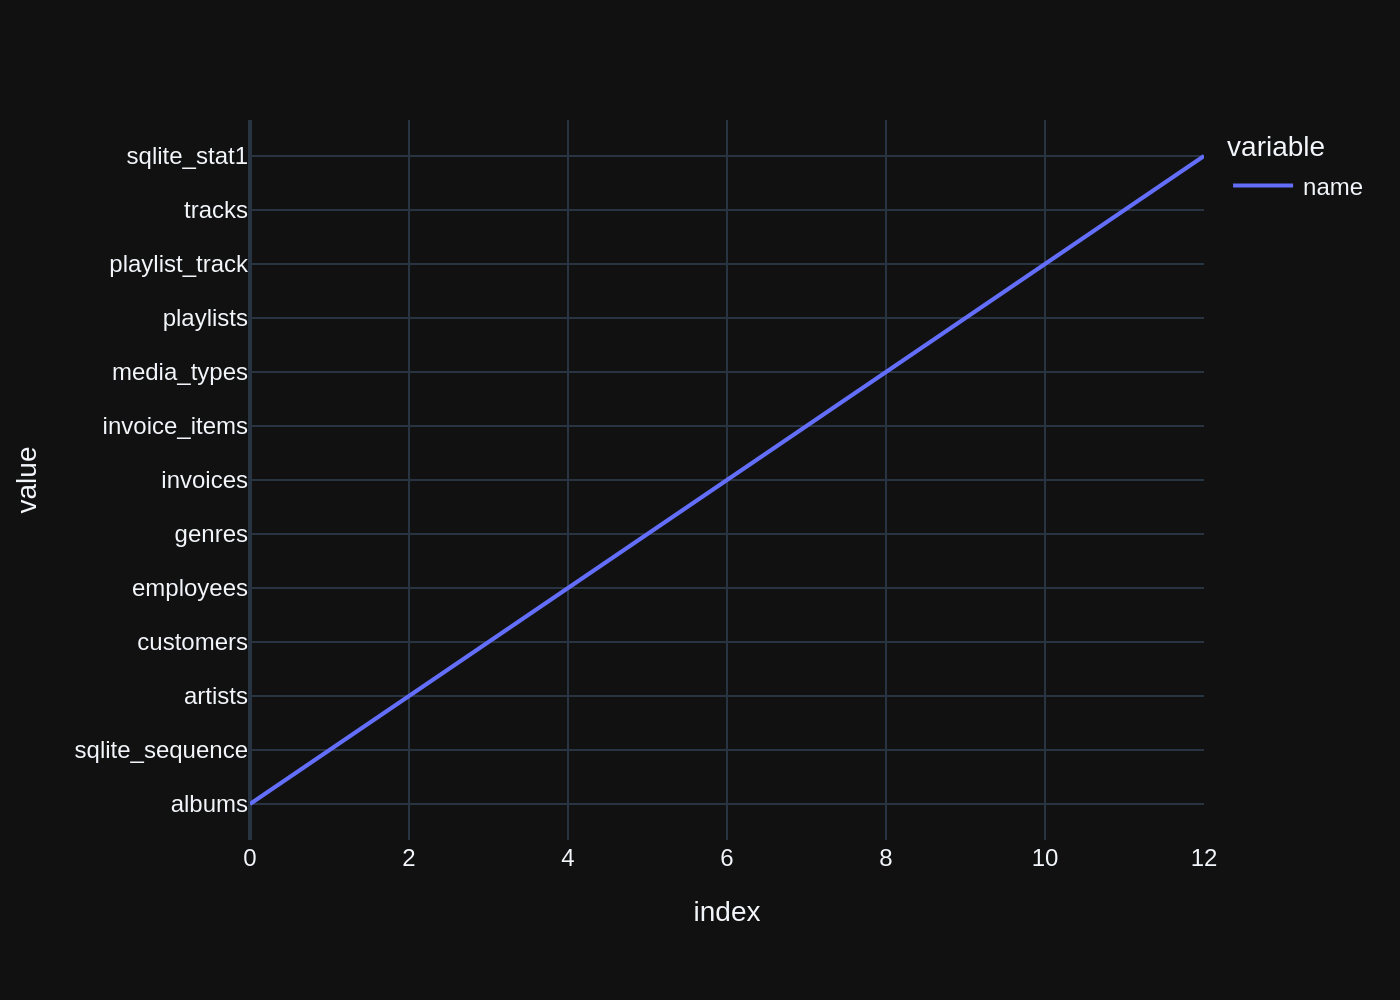

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 3:  which table stores customer's orders


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n

SELECT name FROM sqlite_master WHERE type='table' AND name='invoices'


[( DATA )]
queried dataframe


,name
0,invoices



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(mode='number', value=df['name'][0]))
else:
    fig = px.scatter(df, y='name')

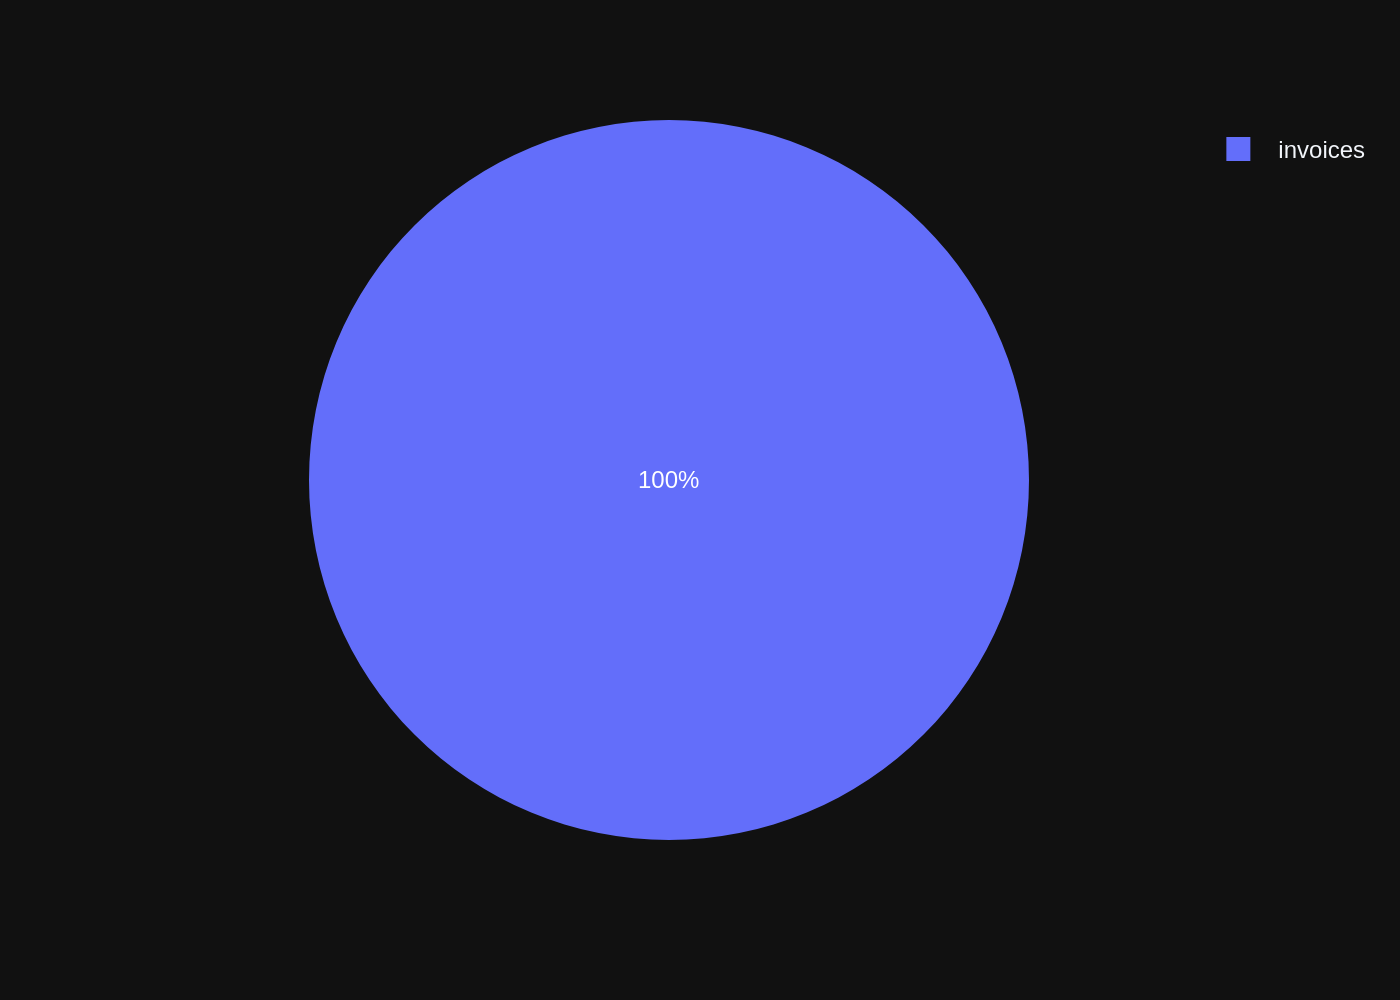

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 4:  How many customers are there


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName 

In [ ]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    vn.ask_adaptive(question=question, tag_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

### Check completion time

In [ ]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

In [ ]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

### Save training data

In [ ]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

In [ ]:
df_training_data.to_csv(file_csv, index=False)